In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import requests
import datetime
import time
from collections import Counter
import csv
import duckdb
import folium

In [7]:
#Leitura do arquivo csv com todos os check-in realizados no estado do Tenneesse ao longo de 2010
#Para cada usuario (id), vai existir um grafo direcionado onde os vértices são os estabelecimentos de check-in (location_id)
    
df = pd.read_csv("arquivo_final.csv", sep=",")
df.columns = ['id_user', 'time', 'latitude', 'longitude' ,'location_id']

df['time'] = pd.to_datetime(df['time'])

df.head()

,id_user,time,latitude,longitude,location_id
0,17,2010-10-16 00:07:34+00:00,35.046108,-89.827722,864095
1,17,2010-10-14 14:38:26+00:00,35.072080,-89.948233,26904
2,17,2010-09-26 18:05:52+00:00,35.149988,-89.994296,35812
3,17,2010-09-25 21:37:20+00:00,35.176795,-89.916894,1214560
4,17,2010-09-25 18:54:52+00:00,35.154289,-89.993104,4425307


In [8]:
#Número de check-in por usuários

def total_check_users(df):
    number_location = []
    prim = df['id_user'][0]
    
    cont = 1
    
    for i in range(len(df)):
        if i+1 == len(df):
            number_location.append(cont)
        elif df['id_user'][i] == prim:
            cont+=1 
        else:
            number_location.append(cont)
            cont = 1
            prim = df['id_user'][i]

    return number_location

#print(number_location)
tam_checks = len(total_check_users(df))
print(tam_checks)

2534


In [9]:
#Filtrando a quantidade de usuarios que esteve no estado durante as chuvas (01/05/2010 e 02/05/2010)
'''
Observação: Alterando as datas na variavel "query", é possível acompanhar a alteração na quantidade de pessoas no estado
do Tennessee e acompanhar quantas pessoas saíram
'''

# Convertendo a coluna 'time' para datetime no pandas
df['time'] = pd.to_datetime(df['time'])

#Usando duckdb para realizar uma consulta SQL 
con = duckdb.connect()
con.register('df', df)

query = """
SELECT * 
FROM df 
WHERE 
STRFTIME('%Y-%m-%dT%H:%M:%S', CAST(time AS TIMESTAMP)) LIKE '2010-05-01T%' 
OR 
STRFTIME('%Y-%m-%dT%H:%M:%S', CAST(time AS TIMESTAMP)) LIKE '2010-05-02T%'
"""

res = con.execute(query).fetchall()

# Obter e contar os usuários únicos
quant_users = set(row[0] for row in res)

print("Existiam %d pessoas no Tennessee na data das chuvas" % (len(quant_users)))


Existiam 107 pessoas no Tennessee na data das chuvas


In [10]:
#Criando o novo dataframe
lista = []

for valor in res:
    aux = []
    aux.append(valor[0])
    aux.append(valor[1])
    aux.append(valor[2])
    aux.append(valor[3])
    aux.append(valor[4])
    lista.append(aux)

df_new = pd.DataFrame(lista)
df_new .columns = ['id_user', 'time', 'latitude', 'longitude' ,'location_id']
df_new.head()

print(len(df_new))

258


In [11]:
#Número de check-in por usuários

aux = []
freq_users = []

#Pegando cada um dos id_users
for i in range(len(df_new)):
    aux.append((df_new['id_user'][i]))

#Counter = par chave, valor dos id_user e a quantidade de vezes que aparecem
for i in Counter(aux).values():
    freq_users.append(i)

print(freq_users)

[1, 10, 7, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 6, 4, 5, 3, 2, 1, 1, 8, 4, 1, 2, 3, 3, 2, 1, 1, 1, 5, 7, 5, 3, 1, 1, 5, 3, 3, 2, 1, 1, 3, 3, 2, 1, 1, 1, 1, 1, 3, 1, 2, 1, 2, 1, 1, 2, 1, 3, 1, 4, 1, 3, 6, 1, 1, 1, 2, 2, 1, 3, 1, 2, 1, 3, 1, 1, 1, 9, 3, 1, 4, 3, 2, 1, 1, 6, 3, 3, 4, 3, 1, 1, 4, 4, 2, 1, 3, 1, 2, 3, 1, 4, 2, 1]


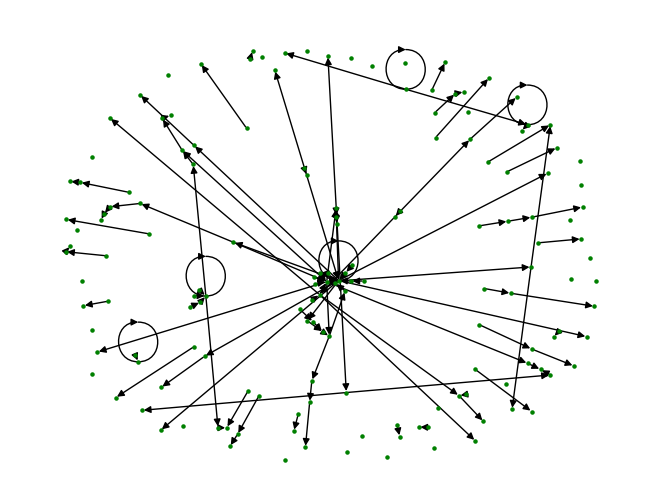

In [13]:
#Plote do grafo direcionado, onde a sequência de vértices respeita a ordem temporal dos check-in

df_new = df_new.sort_values(by="id_user")

G = nx.DiGraph()

for i in range(len(df_new)):
    if (i+1) < len(df_new) and df_new["id_user"][i] == df_new["id_user"][i+1]:
        origem = df['location_id'][i]
        destino = df['location_id'][i+1]
        G.add_edge(origem, destino)
    else:
        G.add_node(df['location_id'][i])

nx.draw(G, node_color='green', node_size=5)

In [14]:
#Plotar do grafo direcionado em um mapa

lat = df_new['latitude'][0]
long = df_new['longitude'][0]

mapa = folium.Map(location = [lat, long])
coordinates = []
coordinates_aux = []
z = 0

for num_users in freq_users:
    for i in range(z, z+num_users):
        z+=1
        coord_aux = []
        coord_aux.append(df_new['latitude'][i])
        coord_aux.append(df_new['longitude'][i])
        coordinates_aux.append(coord_aux)
    coordinates.append(coordinates_aux)
    coordinates_aux = []

for geom in coordinates:
    if len(geom) == 1:
        iframe = folium.IFrame(str(i))
        iframe = folium.IFrame(str(df_new['time'][i]))
        popup = folium.Popup(iframe, min_width=200, max_width=200)
        folium.Marker(location=[geom[0][0], geom[0][1]], popup=popup).add_to(mapa)
    else:
        for ponto in geom:
            iframe = folium.IFrame(str(i))
            iframe = folium.IFrame(str(df_new['time'][i]))
            popup = folium.Popup(iframe, min_width=200, max_width=200)
            folium.Marker(location=[ponto[0], ponto[1]], popup=popup).add_to(mapa)
        folium.PolyLine(locations=[geom], weight=5).add_to(mapa)
        
mapa

In [15]:
#2)a)
'''
Entre os dias 01 e 02 de maio de 2010, fortes chuvas causaram graves inundações no estado norte-americano do Tennessee.
Para se ter uma ideia da tragédia, mais de 20 pessoas morreram e centenas precisaram de serem resgatadas. Sendo assim,
a rede complexa aqui modelada busca representar o histórico de check-in realizados na rede social Gowala durante os 
dois dias do desastre. A modelagem ocorreu da seguinte forma: para cada usuário que realizou um ou mais check-in, foi criado
para ele um grafo onde os vértices representam os estabelecimentos e as arestas a sequência entre um check-in e outro.
'''

'\nEntre os dias 01 e 02 de maio de 2010, fortes chuvas causaram graves inundações no estado norte-americano do Tennessee.\nPara se ter uma ideia da tragédia, mais de 20 pessoas morreram e centenas precisaram de serem resgatadas. Sendo assim,\na rede complexa aqui modelada busca representar o histórico de check-in realizados na rede social Gowala durante os \ndois dias do desastre. A modelagem ocorreu da seguinte forma: para cada usuário que realizou um ou mais check-in, foi criado\npara ele um grafo onde os vértices representam os estabelecimentos e as arestas a sequência entre um check-in e outro.\n'

dict_items([(0, 62), (5, 2), (2, 11), (1, 78), (4, 1)])


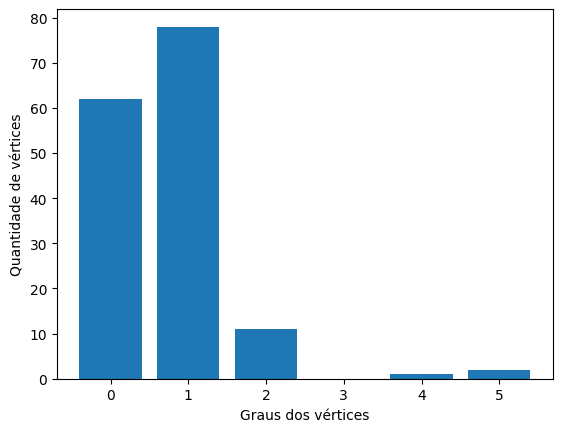

In [10]:
#2)b)
'''
Como cada vértice representa um estabelecimento onde é feito um check-in, o número de graus de entrada do vértice, nesse caso, indicaria
a quantidade de vezes que aquele determinado estabelecimento foi visitado por um usuário da rede social. Como era esperado, a maior
parte dos vértices possui grau 0 ou 1, indicando assim que a maior parte dos usuários realizou ou um único check-in na rede social durante 
os dois dias de desastres ou somente um check-in em cada estabelecimento distinto.
'''
graus = []

for node, grau in G.in_degree():
    graus.append(grau)

num_graus = Counter(graus)
x = num_graus.keys()
y = num_graus.values()

print(num_graus.items())

plt.bar(x,y)
plt.xlabel('Graus dos vértices')
plt.ylabel('Quantidade de vértices')
plt.show()
    

In [17]:
#2)c)
'''
Devido a modelagem da nossa rede complexa, é esperado que exista mais de
um único componente. Nesse caso, o número de componentes é distinto do
número de usuários porque existem um ou mais estabelecimentos que foram
visitados por usuários distintos e, dessa forma, geram um mesmo componente
da rede complexa.
'''

H = G.to_undirected()
num_componentes = nx.number_connected_components(H)
print(num_componentes)

50


Coeficiente de clusterização médio: 0.002361


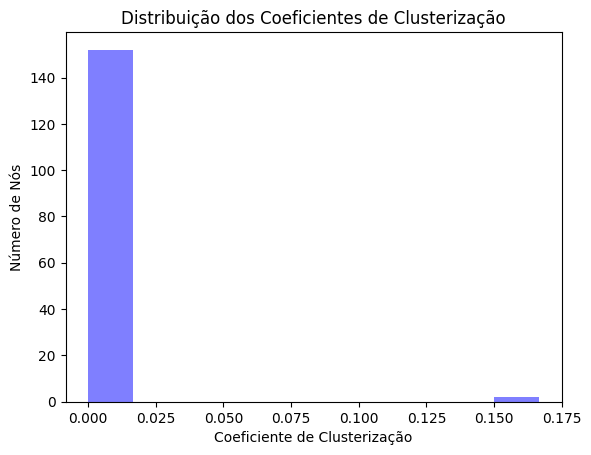

In [18]:
#2)d)
'''
Como há um baixo coeficiente de clusterização, podemos concluir que
a rede complexa formada é uma rede menos coesa e mais esparsa, indicando
assim que os estabelecimentos são visitados, geralmente, uma única vez.
'''

# Calcular o coeficiente de clusterização de cada nó
coeficiente_clusterizacao_medio = nx.average_clustering(G)

print("Coeficiente de clusterização médio: %f" %(coeficiente_clusterizacao_medio))

cluster_coeficientes = nx.clustering(G)

# Plotar a distribuição dos coeficientes de clusterização
plt.hist(list(cluster_coeficientes.values()), bins=10, alpha=0.5, color='b')
plt.xlabel('Coeficiente de Clusterização')
plt.ylabel('Número de Nós')
plt.title('Distribuição dos Coeficientes de Clusterização')

plt.show()

dict_items([(1, 26), (72, 1), (2, 15), (4, 2), (3, 6)])


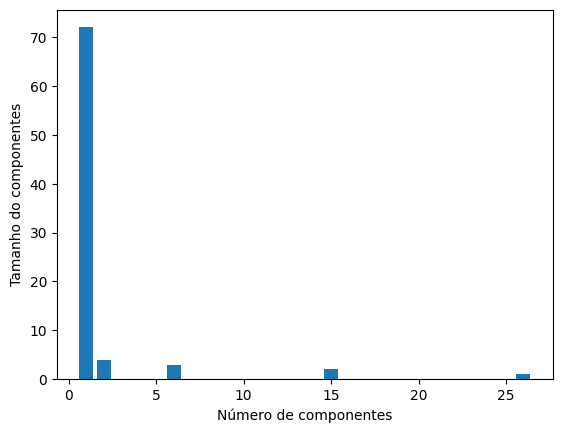

In [13]:
#2)e)
'''
Como há um mesmo estabelecimento que foi visitado por usuários distintos, se considerarmos o grafo formado
como sendo não-direcionado, temos que ambos os usuários formariam um mesmo componente. Dessa forma,
é possível que exista um único componente que concentre uma quantidade maior de vértices nele.
'''
#Transformando o grafo direcionado em não-direcionado para determinar o número de componentes
H = G.to_undirected()

num_componentes = []
for componente in nx.connected_components(H):
    num_componentes.append(len(componente))

total_componentes = Counter(num_componentes)

x = total_componentes.values()
y = total_componentes.keys()

print(total_componentes.items())

plt.bar(x,y)
plt.xlabel('Número de componentes')
plt.ylabel('Tamanho do componentes')
plt.show()

dict_items([(0.0, 3555), (1.0, 35), (0.5, 9), (0.14285714285714285, 5), (0.2222222222222222, 1), (0.1111111111111111, 3), (0.25, 5), (0.3333333333333333, 3)])


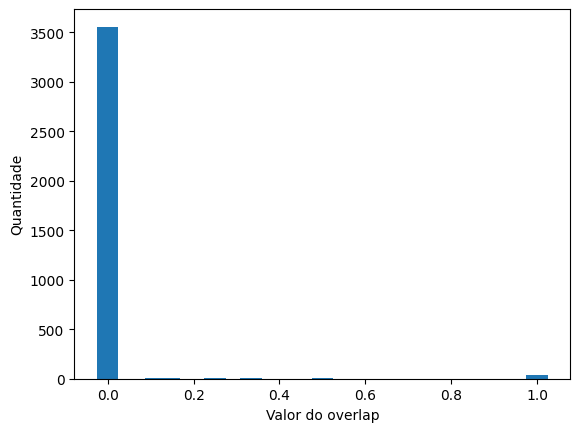

In [19]:
#2)f)
'''
Mesmo considerando o componente com o maior número de vértices, podemos considerar
que a rede complexa apresenta baixa sobreposição, uma vez que a maioria dos valores
encontrados é nulo. Assim, no nosso contexto, isso indica que durante o desastre,
as pessoas buscaram não se aglomerar, visitando assim locais distintos.
'''

#Overlap 
# O(u,v) = (vizinho comuns de u e v) / (vizinhos de u + vizinho de v)
# O(u,v) = intercesão dos vizinhos de u e v / união dos vizinhos de u e v

#Gerando o overlap do maior componente do grafo analisado

hist_overlap = []

#Gerando todos os componentes do grafo
componentes = nx.connected_components(H)
for i in componentes:
    #Considerando somente o maior componente
    if len(i) == 72:
        #Considerando o subgrafo do grafo direcionado
        subgrafo_G = G.subgraph(i)

for u in subgrafo_G.nodes():
    for v in subgrafo_G.nodes():
        if u != v and not subgrafo_G.has_edge(u, v):
            vizinhos_1 = set(subgrafo_G.neighbors(u))
            vizinhos_2 = set(subgrafo_G.neighbors(v))

            vizinhos_comuns = vizinhos_1.intersection(vizinhos_2)
            vizinhos_todos = vizinhos_1.union(vizinhos_1)

            if len(vizinhos_todos) != 0:
                overlap = len(vizinhos_comuns) / len(vizinhos_todos)
                hist_overlap.append(overlap)

plot_valores = Counter(hist_overlap)

print(plot_valores.items())

x = plot_valores.keys()
y = plot_valores.values()

bar_width = 0.05
plt.bar(x,y, bar_width)
plt.xlabel('Valor do overlap')
plt.ylabel('Quantidade')
plt.show()


Distância média: 4.464789


dict_items([(0, 72), (1, 76), (2, 127), (3, 182), (4, 169), (5, 154), (6, 120), (7, 77), (8, 54), (9, 45), (10, 29), (11, 15), (12, 10), (13, 5), (14, 1)])


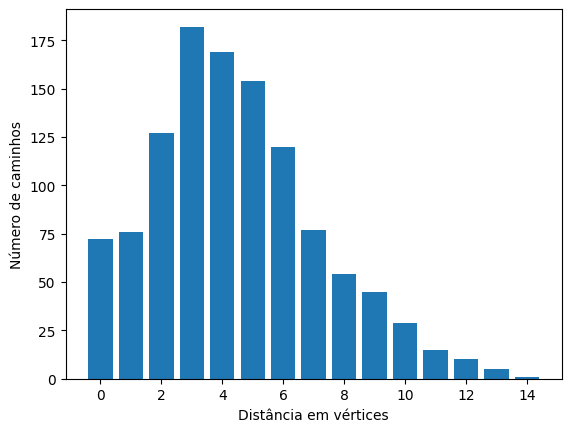

In [20]:
#2)g)
'''
'''

#Gerando todos os componentes do grafo
componentes = nx.connected_components(H)
for i in componentes:
    #Considerando somente o maior componente
    if len(i) == 72:
        #Considerando o subgrafo do grafo direcionado
        subgrafo_G = G.subgraph(i)

#nx.draw(subgrafo_G, node_color='green', node_size=5)

distancias = dict(nx.all_pairs_shortest_path_length(subgrafo_G))
distribuicao_distancia = []

#Gerando todas as distâncias
for u, v_dist in distancias.items():
    for v, dist in v_dist.items():
        #print("Distância de %u para %d: %d" % (u, v, dist))
        distribuicao_distancia.append(dist)

dist_valores = Counter(distribuicao_distancia)

x = dist_valores.keys()
y = dist_valores.values()

valores = 0
total = 0

#Calculando a distância média manualmente
for k,v in dist_valores.items():
    valores += k*v
    total += v

media = valores/total

print("Distância média: %f" % (media))
print("\n")

print(dist_valores.items())

plt.bar(x,y)
plt.xlabel('Distância em vértices')
plt.ylabel('Número de caminhos')
plt.show()


In [ ]:
#2)h)